In [1]:
import tensorflow as tf
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import MeanIoU
from sklearn.preprocessing import StandardScaler
import albumentations as A

# Load data from Kaggle

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle competitions download <name-of-competition>
! kaggle datasets download mateuszbuda/lgg-mri-segmentation

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
100% 714M/714M [00:05<00:00, 195MB/s]
100% 714M/714M [00:05<00:00, 131MB/s]


In [3]:
! unzip /content/lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [4]:
directory='/content/lgg-mri-segmentation/kaggle_3m'
file_list=os.listdir(directory)

IMG_Width= 128
IMG_Height=128
IMG_Channel=3
images=[]
masks=[]
for files in file_list:
  path=os.path.join(directory,files)
  try:
    for image_names in os.listdir(path): #######
      if  '_mask' not in image_names: #  file_name.endswith('.tif')
          image_path=os.path.join(path,image_names)
          mask_path=os.path.join(path,image_names.replace('.tif','_mask.tif'))

          image= img_to_array(load_img(image_path,target_size=(IMG_Width, IMG_Height))) #Preprocessing : Resizing
          mask=img_to_array(load_img(mask_path,target_size=(IMG_Width, IMG_Height),color_mode='grayscale'))
          image= image / 255.0
          mask = mask / 255.0
          mask=(mask>0.5).astype(int)
          images.append(image)
          masks.append(mask)
  except NotADirectoryError:
        continue

images =np.array(images)
masks= np.array(masks)

images_reshaped= images.reshape(-1,images.shape[-1])
scaler =StandardScaler()                             #Preprocessing : Resacling(Z-score)
images_scaled=scaler.fit_transform(images_reshaped )
images_scaled= images_scaled.reshape(images.shape)

# images vs masks

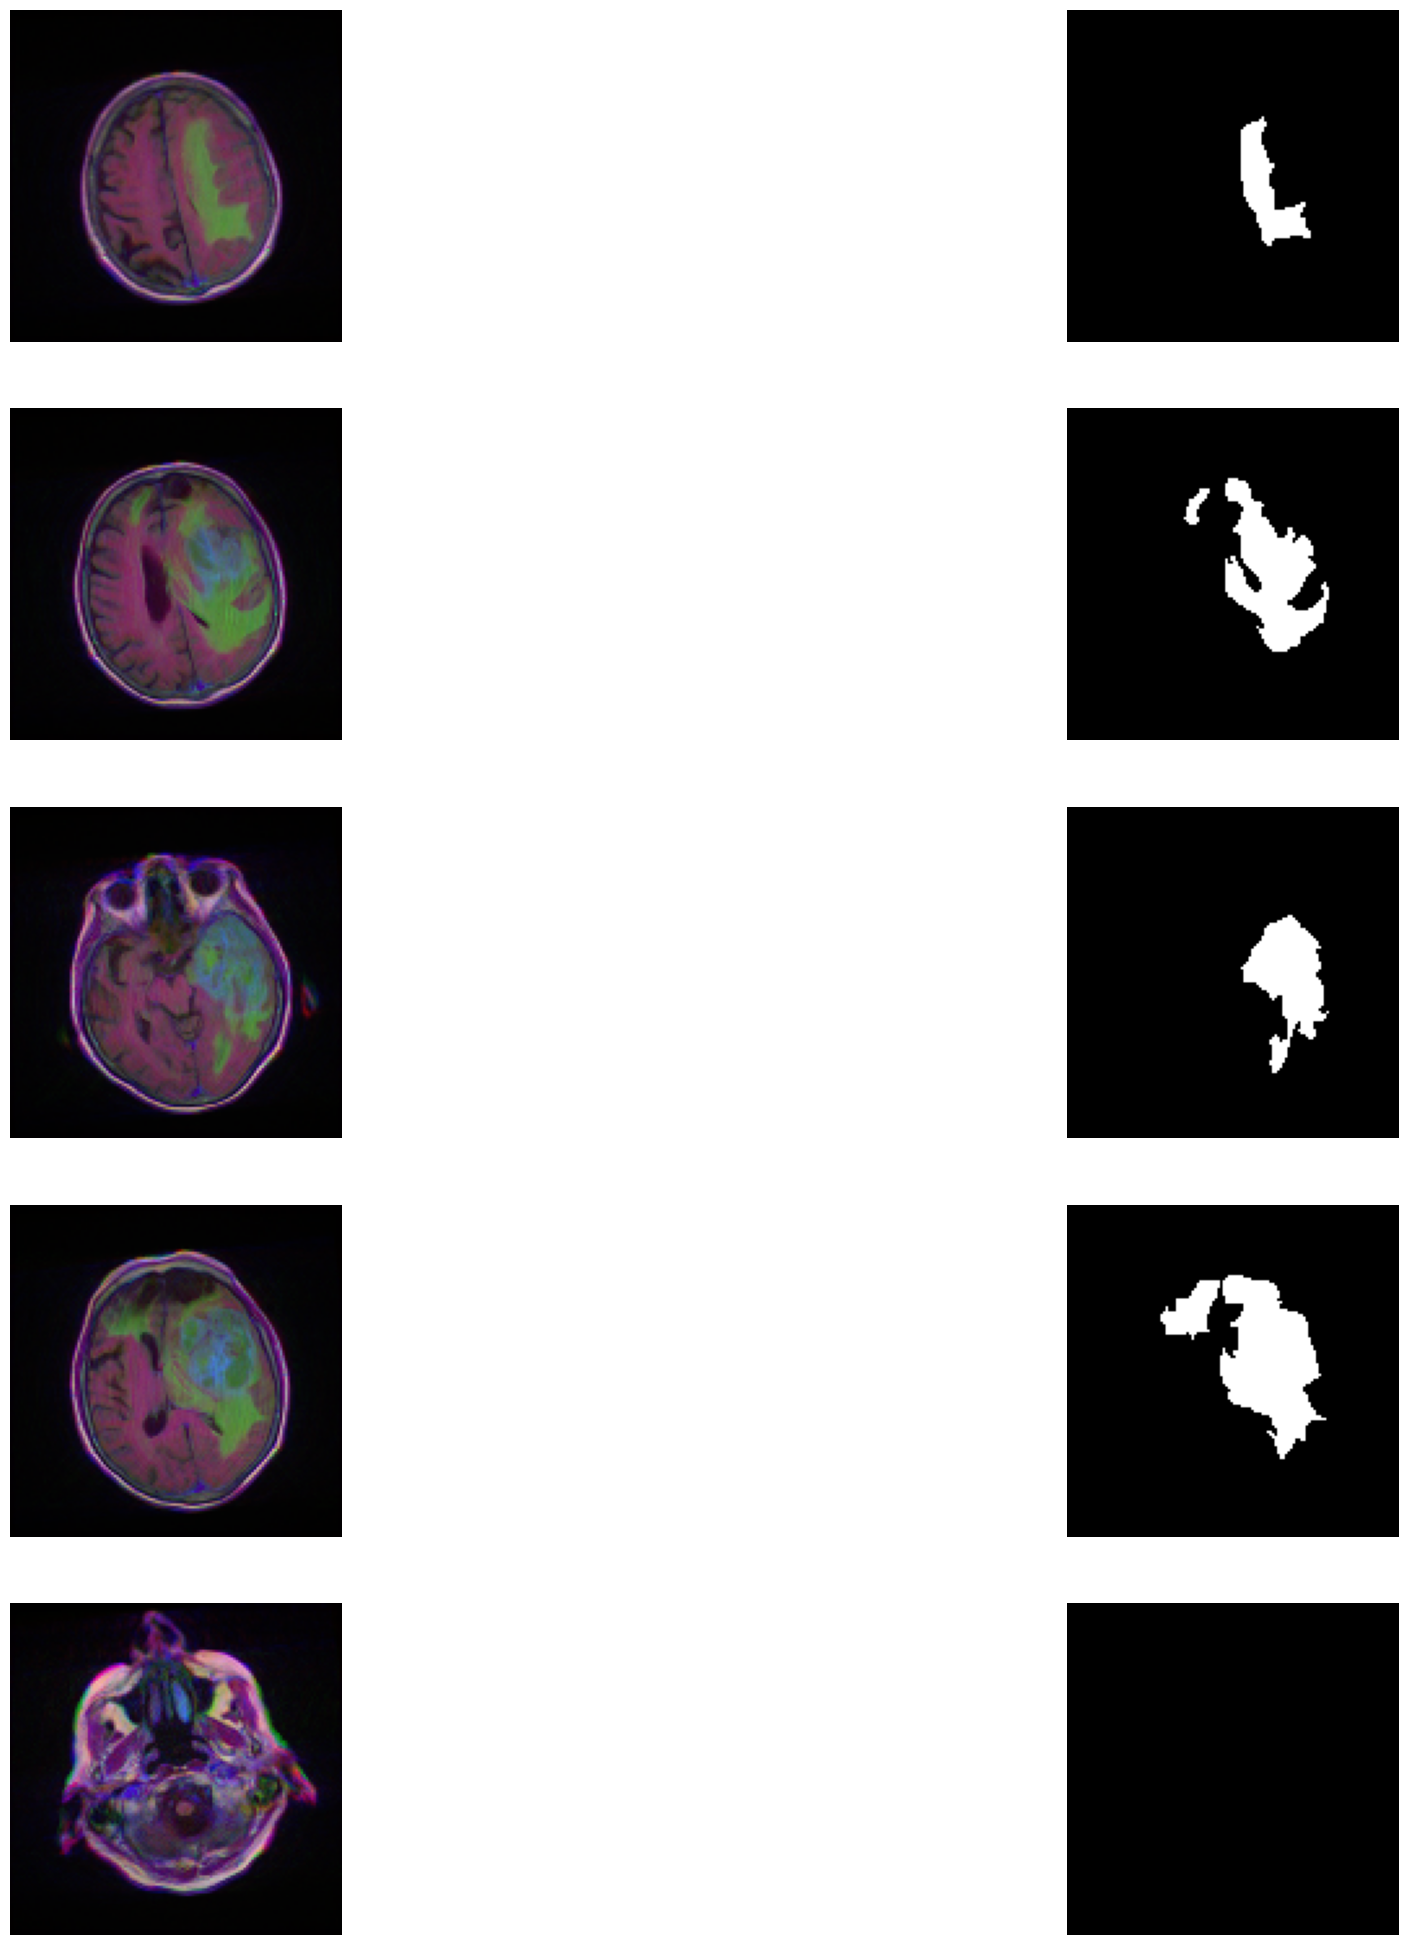

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(25, 25))

for i in range(5):
    ax[i, 0].imshow(images[27+i])
    ax[i, 1].imshow(masks[i+27], cmap='gray')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

plt.show()

# Data Augmentation- samples

In [ ]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))
        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))
        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

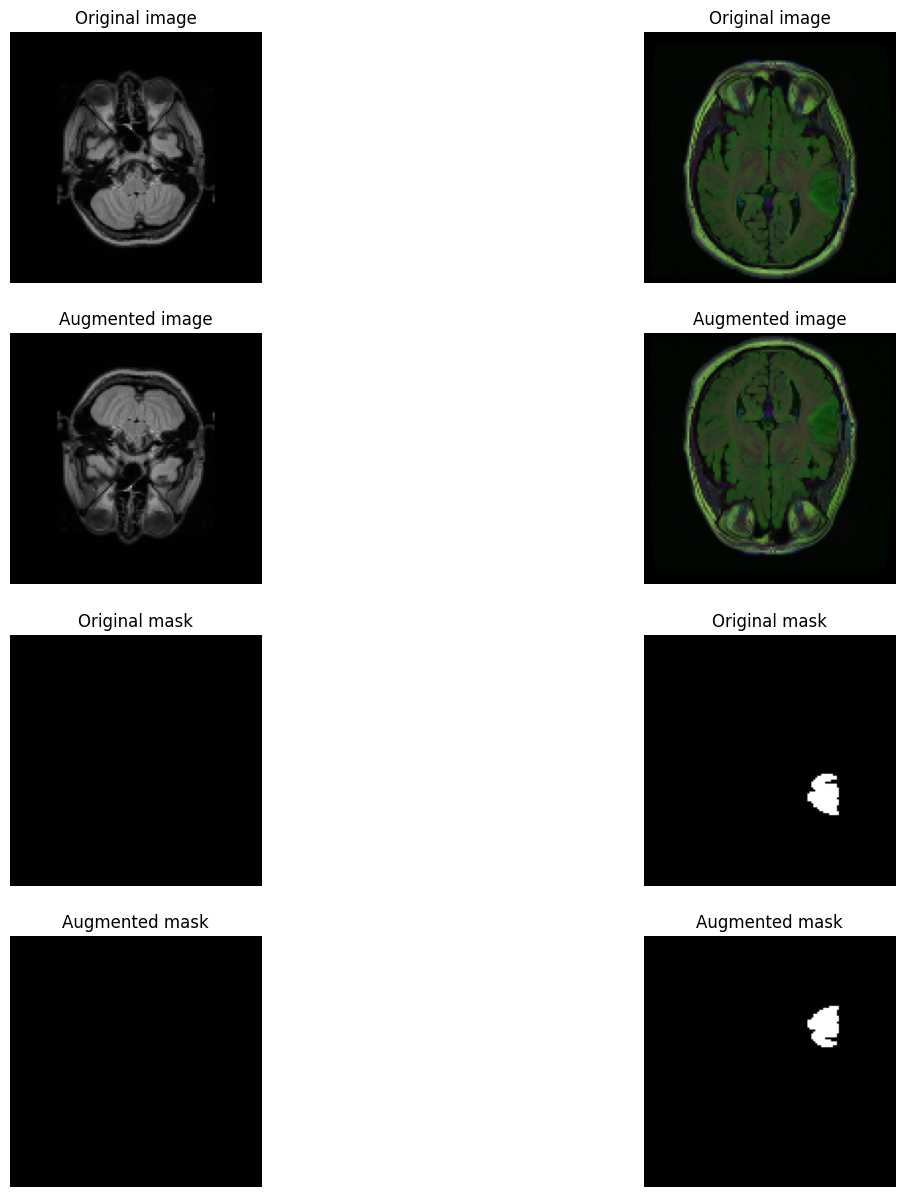

In [ ]:
i=0
augmented_images=np.array([])
augmented_masks=np.array([])
dummy_image = np.zeros((1, 128, 128, 3))
dummy_mask = np.zeros((1, 128, 128, 3))
augmented_images = dummy_image
augmented_masks = dummy_mask
rr = random.sample(range(len(images)), 2)

for r in rr:
  aug = A.VerticalFlip(p=1)
  augmented = aug(image=images[r]/255, mask=masks[r])
  augmented_images = np.append(augmented_images,np.expand_dims(augmented['image'], axis=0), axis=0)
  augmented_masks = np.append(augmented_masks,np.expand_dims(augmented['mask'], axis=0), axis=0)


fig, axs = plt.subplots(4,2, figsize=(15, 15))
for i,r in zip(range(5),rr):
    axs[0,i].imshow(images[r]/255)
    axs[0,i].set_title('Original image')

    axs[1,i].imshow(augmented_images[i+1])
    axs[1,i].set_title('Augmented image')

    axs[2,i].imshow(masks[r])
    axs[2,i].set_title('Original mask')

    axs[3,i].imshow(augmented_masks[i+1])
    axs[3,i].set_title('Augmented mask')

    axs[0,i].axis('off')
    axs[1,i].axis('off')
    axs[2,i].axis('off')
    axs[3,i].axis('off')
plt.show()

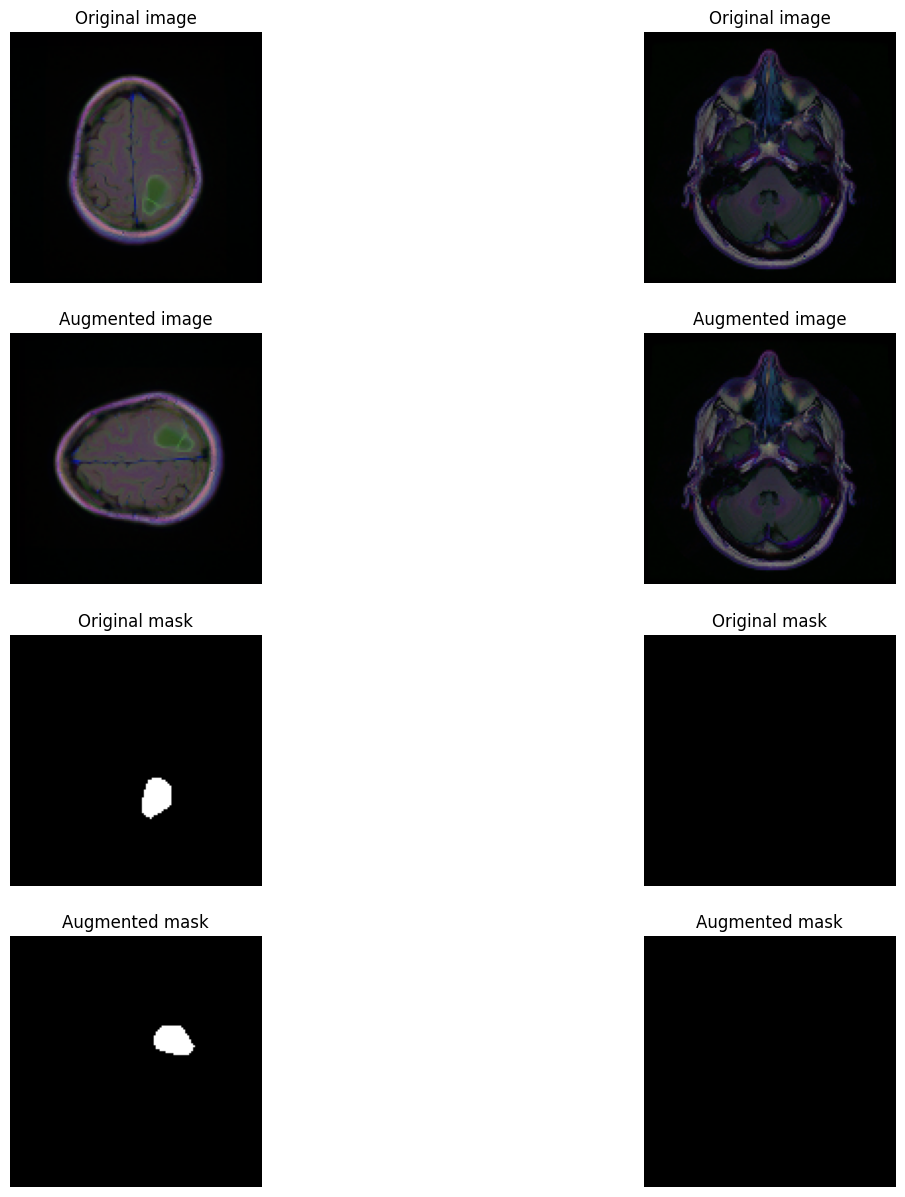

In [ ]:
i=0
augmented_images=np.array([])
augmented_masks=np.array([])
dummy_image = np.zeros((1, 64, 128, 3))
dummy_mask = np.zeros((1, 128, 128, 3))
augmented_images = dummy_image
augmented_masks = dummy_mask
rr = random.sample(range(len(images)), 2)

for r in rr:
  aug = A.RandomRotate90(p=1)
  augmented = aug(image=images[r]/255, mask=masks[r])
  augmented_images = np.append(augmented_images,np.expand_dims(augmented['image'], axis=0), axis=0)
  augmented_masks = np.append(augmented_masks,np.expand_dims(augmented['mask'], axis=0), axis=0)


fig, axs = plt.subplots(4,2, figsize=(15, 15))
for i,r in zip(range(5),rr):
    axs[0,i].imshow(images[r]/255)
    axs[0,i].set_title('Original image')

    axs[1,i].imshow(augmented_images[i+1])
    axs[1,i].set_title('Augmented image')

    axs[2,i].imshow(masks[r])
    axs[2,i].set_title('Original mask')

    axs[3,i].imshow(augmented_masks[i+1])
    axs[3,i].set_title('Augmented mask')

    axs[0,i].axis('off')
    axs[1,i].axis('off')
    axs[2,i].axis('off')
    axs[3,i].axis('off')
plt.show()

# Data Augmentation- main

In [5]:
black_masks_indices = []
white_masks_indices = []

for i  in range(len(masks)):
     if np.all(masks[i] == 0):
        black_masks_indices.append(i)
     if np.any(masks[i] != 0):
        white_masks_indices.append(i)

print(f"ID of white maskswith len {len(white_masks_indices)} :{white_masks_indices}")
print(f"ID of black maskswith len {len(black_masks_indices)} :{black_masks_indices}")


ID of white maskswith len 1373 :[11, 14, 21, 22, 23, 34, 36, 37, 39, 40, 46, 57, 61, 67, 75, 76, 78, 79, 84, 85, 90, 91, 92, 94, 96, 98, 99, 100, 102, 106, 107, 111, 116, 120, 121, 122, 123, 125, 127, 132, 142, 143, 147, 153, 162, 164, 165, 167, 175, 179, 180, 181, 184, 187, 188, 189, 191, 192, 195, 199, 203, 205, 206, 211, 215, 217, 219, 221, 228, 230, 231, 237, 238, 247, 253, 254, 256, 258, 261, 263, 264, 271, 277, 279, 280, 284, 286, 289, 290, 295, 297, 298, 300, 304, 307, 308, 309, 310, 311, 315, 321, 322, 325, 327, 328, 335, 336, 340, 341, 343, 347, 348, 350, 352, 353, 355, 356, 358, 362, 365, 367, 369, 371, 376, 377, 380, 381, 382, 385, 388, 389, 391, 392, 394, 395, 396, 398, 399, 401, 402, 403, 404, 406, 408, 410, 413, 414, 415, 426, 429, 431, 433, 436, 438, 439, 445, 448, 450, 451, 461, 462, 463, 466, 469, 473, 475, 476, 480, 481, 483, 487, 488, 489, 492, 495, 501, 504, 506, 507, 508, 511, 516, 519, 521, 523, 525, 527, 529, 530, 532, 533, 537, 543, 546, 552, 553, 554, 557, 559,

*just to make sure and see:*

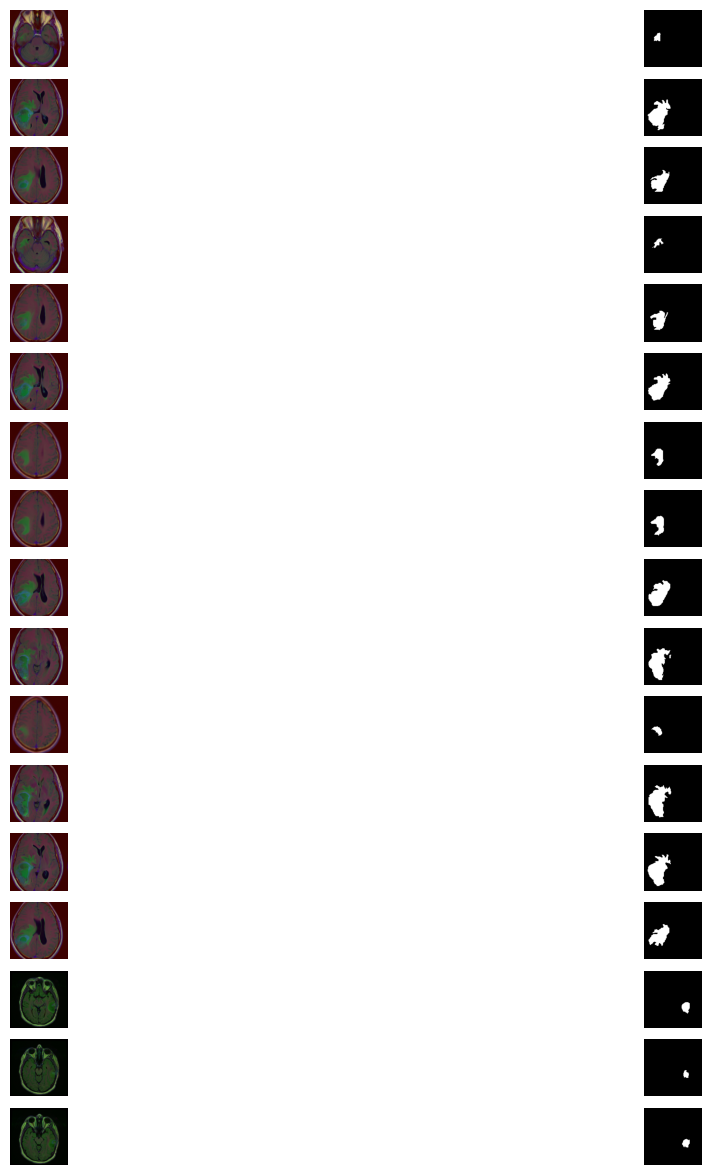

In [ ]:
rrr=[0, 1, 2, 3, 4, 6, 7, 9, 10, 19, 23, 28, 31, 32, 37, 58, 59,]
fig, axs = plt.subplots(len(rrr),2, figsize=(15, 15))
for i,r in zip(range(len(rrr)),rrr):
    axs[i,0].imshow(images[r])
    axs[i,1].imshow(masks[r])
    axs[i,0].axis('off')
    axs[i,1].axis('off')
plt.show()

In [6]:
i=0
augmented_images=np.array([])
augmented_masks=np.array([])
ww=128
dummy_image = np.zeros((1, ww, ww, 3))
dummy_mask = np.zeros((1, ww, ww, 1))
augmented_images = dummy_image
augmented_masks = dummy_mask
rr = random.sample(white_masks_indices, 1010)
total=0
while total < 1000:
  r=rr[total]
  aug = A.VerticalFlip(p=1)
  augmented = aug(image=images[r], mask=masks[r])
  augmented_images = np.append(augmented_images,np.expand_dims(augmented['image'], axis=0), axis=0)
  augmented_masks = np.append(augmented_masks,np.expand_dims(augmented['mask'], axis=0), axis=0)
  r=rr[total+1]
  aug = A.HorizontalFlip(p=1)
  augmented = aug(image=images[r], mask=masks[r])
  augmented_images = np.append(augmented_images,np.expand_dims(augmented['image'], axis=0), axis=0)
  augmented_masks = np.append(augmented_masks,np.expand_dims(augmented['mask'], axis=0), axis=0)
  r=rr[total+2]
  aug =A.RandomRotate90(p=1)
  augmented = aug(image=images[r], mask=masks[r])
  augmented_images = np.append(augmented_images,np.expand_dims(augmented['image'], axis=0), axis=0)
  augmented_masks = np.append(augmented_masks,np.expand_dims(augmented['mask'], axis=0), axis=0)
  total+=3
data_images=np.concatenate((images,augmented_images[1:]),axis=0)
data_masks= np.concatenate((masks,augmented_masks[1:]),axis=0)

In [7]:
black_masks_indices = []
white_masks_indices = []

for i  in range(len(data_images)):
     if np.all(data_masks[i] == 0):
        black_masks_indices.append(i)
     if np.any(data_masks[i] != 0):
        white_masks_indices.append(i)
print('AFTER DATA AUGMENTATION:')
print(f"ID of white maskswith len {len(white_masks_indices)} :{white_masks_indices}")
print(f"ID of black maskswith len {len(black_masks_indices)} :{black_masks_indices}")


AFTER DATA AUGMENTATION:
ID of white maskswith len 2375 :[11, 14, 21, 22, 23, 34, 36, 37, 39, 40, 46, 57, 61, 67, 75, 76, 78, 79, 84, 85, 90, 91, 92, 94, 96, 98, 99, 100, 102, 106, 107, 111, 116, 120, 121, 122, 123, 125, 127, 132, 142, 143, 147, 153, 162, 164, 165, 167, 175, 179, 180, 181, 184, 187, 188, 189, 191, 192, 195, 199, 203, 205, 206, 211, 215, 217, 219, 221, 228, 230, 231, 237, 238, 247, 253, 254, 256, 258, 261, 263, 264, 271, 277, 279, 280, 284, 286, 289, 290, 295, 297, 298, 300, 304, 307, 308, 309, 310, 311, 315, 321, 322, 325, 327, 328, 335, 336, 340, 341, 343, 347, 348, 350, 352, 353, 355, 356, 358, 362, 365, 367, 369, 371, 376, 377, 380, 381, 382, 385, 388, 389, 391, 392, 394, 395, 396, 398, 399, 401, 402, 403, 404, 406, 408, 410, 413, 414, 415, 426, 429, 431, 433, 436, 438, 439, 445, 448, 450, 451, 461, 462, 463, 466, 469, 473, 475, 476, 480, 481, 483, 487, 488, 489, 492, 495, 501, 504, 506, 507, 508, 511, 516, 519, 521, 523, 525, 527, 529, 530, 532, 533, 537, 543, 546,

In [ ]:
masks.shape

(3929, 128, 128, 1)

# train-test split

In [8]:
id_split=round(len(data_images)*0.1)

#train
X_train=data_images[id_split:]
y_train=data_masks[id_split:]

#test
X_test=data_images[:id_split]
y_test=data_masks[:id_split]

# U-net

In [ ]:
X_train.shape

(4438, 128, 128, 3)

In [ ]:
y_train.shape

(4438, 128, 128, 1)

In [9]:
def dice_coef(y_true,y_pred,ss=1):
    intersection= K.sum(K.abs(y_true *y_pred),axis=[1,2,3])
    union=K.sum(y_true,axis=[1,2,3])+K.sum(y_pred,axis=[1,2,3])
    dice=K.mean((2.*intersection+ss)/(union+ss),axis=0)
    return dice
def dice_coef_loss(y_true,y_pred):
    return 1-dice_coef(y_true,y_pred)
def jacard_coef(y_true,y_pred):
    y_true_f=K.flatten(y_true)
    y_pred_f=K.flatten(y_pred)
    intersection=K.sum(y_true_f*y_pred_f)
    return (intersection +1.0)/(K.sum(y_true_f)+ K.sum(y_pred_f)-intersection+1.0)

#Model9:128*128,drop out=0.1 ,batch_size=16,epochs=100, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,IoU]


In [10]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3

inputs=Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=inputs
#Encoding
c1=Conv2D(16,(3,3),input_shape=X_train.shape[1:],activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=Dropout(0.1)(c1)
c1=Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=MaxPooling2D((2,2))(c1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=Dropout(0.1)(c2)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3= Dropout(0.1)(c3)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4= Dropout(0.1)(c4)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4= MaxPooling2D(pool_size=(2,2))(c4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5= Dropout(0.2)(c5)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
#Decoding
u6= Conv2DTranspose(128,(2,2),strides=(2, 2),padding='same')(c5)
u6= concatenate([u6, c4])
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6= Dropout(0.1)(c6)
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
u7= Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(c6)
u7= concatenate([u7,c3])
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7= Dropout(0.2)(c7)
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
u8= Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8= concatenate([u8, c2])
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8= Dropout(0.1)(c8)
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
u9= Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9= concatenate([u9,c1],axis=3)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9= Dropout(0.1)(c9)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)
outputs= Conv2D(1,(1,1),activation='sigmoid')(c9)
model9=Model(inputs=[inputs],outputs=[outputs])

model9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,jacard_coef])
results9=model9.fit(X_train,y_train,validation_split=0.1,batch_size=16,epochs=100)

accuracy =results9.history['accuracy']
val_accuracy= results9.history['val_accuracy']
epochs= range(1, len(loss) + 1)
plt.plot(epochs, accuracy,'y', label='Training accurcay')
plt.plot(epochs, val_accuracy,'r', label='Validation accurcay')
plt.title('Training and validation accurcay')
plt.xlabel('Epochs')
plt.ylabel('accurcay')
plt.legend()
plt.show()

loss =results9.history['loss']
val_loss = results9.history['val_loss']
epochs= range(1, len(loss)+ 1)
plt.plot(epochs, loss,'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dicecoef =results9.history['dice_coef']
val_dice_coef= results9.history['val_dice_coef']
plt.plot(epochs, dicecoef, 'y', label='Training dice_coef')
plt.plot(epochs,val_dice_coef, 'r', label='Validation dice_coef')
plt.title('Training and validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('dicecoef')
plt.legend()
plt.show()

jacardcoef =results9.history['jacard_coef']
val_jacard_coef=results9.history['val_jacard_coef']
plt.plot(epochs,jacardcoef, 'y', label='Training jacard_coef')
plt.plot(epochs,val_jacard_coef, 'r', label='Validation jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('jacard_coef')
plt.legend()
plt.show()

Epoch 1/100
250/250 [==============================] - 35s 64ms/step - loss: 0.0632 - accuracy: 0.9832 - dice_coef: 0.1238 - jacard_coef: 0.0956 - val_loss: 0.0627 - val_accuracy: 0.9716 - val_dice_coef: 0.2688 - val_jacard_coef: 0.1931
Epoch 2/100
250/250 [==============================] - 12s 48ms/step - loss: 0.0311 - accuracy: 0.9871 - dice_coef: 0.1871 - jacard_coef: 0.1836 - val_loss: 0.0571 - val_accuracy: 0.9720 - val_dice_coef: 0.3218 - val_jacard_coef: 0.2400
Epoch 3/100
250/250 [==============================] - 12s 48ms/step - loss: 0.0272 - accuracy: 0.9907 - dice_coef: 0.2266 - jacard_coef: 0.2620 - val_loss: 0.0553 - val_accuracy: 0.9814 - val_dice_coef: 0.3530 - val_jacard_coef: 0.3092
Epoch 4/100
250/250 [==============================] - 12s 49ms/step - loss: 0.0249 - accuracy: 0.9922 - dice_coef: 0.2471 - jacard_coef: 0.3278 - val_loss: 0.0426 - val_accuracy: 0.9843 - val_dice_coef: 0.4733 - val_jacard_coef: 0.4060
Epoch 5/100
250/250 [==============================]

KeyError: 'accurcay'

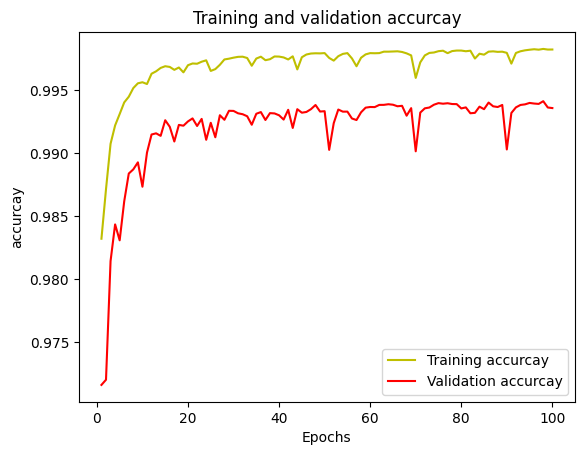

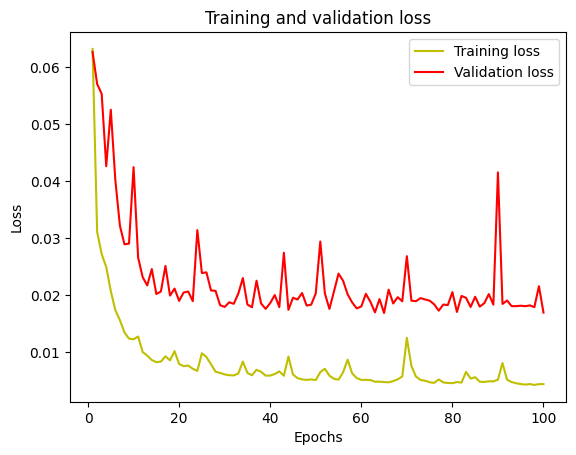

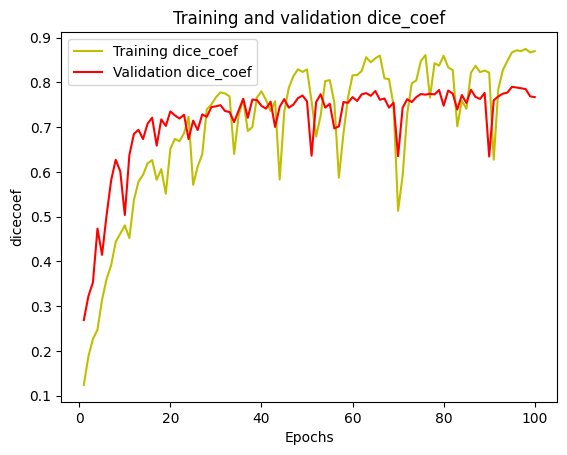

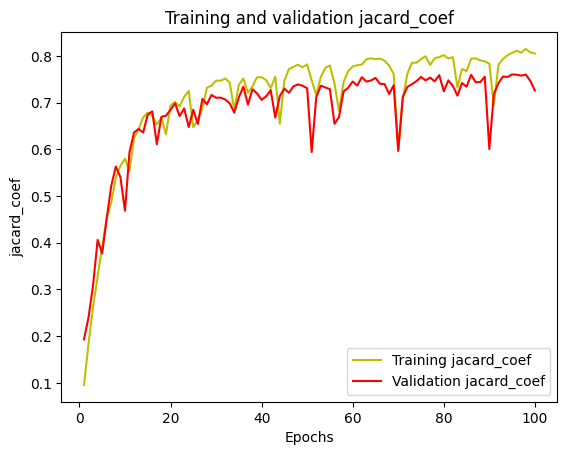

In [12]:

accuracy =results9.history['accuracy']
val_accuracy= results9.history['val_accuracy']
epochs= range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy,'y', label='Training accurcay')
plt.plot(epochs, val_accuracy,'r', label='Validation accurcay')
plt.title('Training and validation accurcay')
plt.xlabel('Epochs')
plt.ylabel('accurcay')
plt.legend()
plt.show()

loss =results9.history['loss']
val_loss = results9.history['val_loss']
epochs= range(1, len(loss)+ 1)
plt.plot(epochs, loss,'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dicecoef =results9.history['dice_coef']
val_dice_coef= results9.history['val_dice_coef']
plt.plot(epochs, dicecoef, 'y', label='Training dice_coef')
plt.plot(epochs,val_dice_coef, 'r', label='Validation dice_coef')
plt.title('Training and validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('dicecoef')
plt.legend()
plt.show()

jacardcoef =results9.history['jacard_coef']
val_jacard_coef=results9.history['val_jacard_coef']
plt.plot(epochs,jacardcoef, 'y', label='Training jacard_coef')
plt.plot(epochs,val_jacard_coef, 'r', label='Validation jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('jacard_coef')
plt.legend()
plt.show()

#Model8:128*128,No drop out ,batch_size=16,epochs=64, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,IoU]


Epoch 1/64
250/250 [==============================] - 25s 55ms/step - loss: 0.0711 - accuracy: 0.9783 - dice_coef: 0.0964 - jacard_coef: 0.0719 - val_loss: 0.0661 - val_accuracy: 0.9707 - val_dice_coef: 0.2405 - val_jacard_coef: 0.1781
Epoch 2/64
250/250 [==============================] - 9s 37ms/step - loss: 0.0321 - accuracy: 0.9870 - dice_coef: 0.1771 - jacard_coef: 0.1639 - val_loss: 0.0594 - val_accuracy: 0.9708 - val_dice_coef: 0.3048 - val_jacard_coef: 0.2259
Epoch 3/64
250/250 [==============================] - 9s 37ms/step - loss: 0.0274 - accuracy: 0.9901 - dice_coef: 0.2320 - jacard_coef: 0.2597 - val_loss: 0.0504 - val_accuracy: 0.9830 - val_dice_coef: 0.3918 - val_jacard_coef: 0.3476
Epoch 4/64
250/250 [==============================] - 9s 38ms/step - loss: 0.0231 - accuracy: 0.9924 - dice_coef: 0.2853 - jacard_coef: 0.3500 - val_loss: 0.0542 - val_accuracy: 0.9836 - val_dice_coef: 0.4430 - val_jacard_coef: 0.3995
Epoch 5/64
250/250 [==============================] - 9s 37

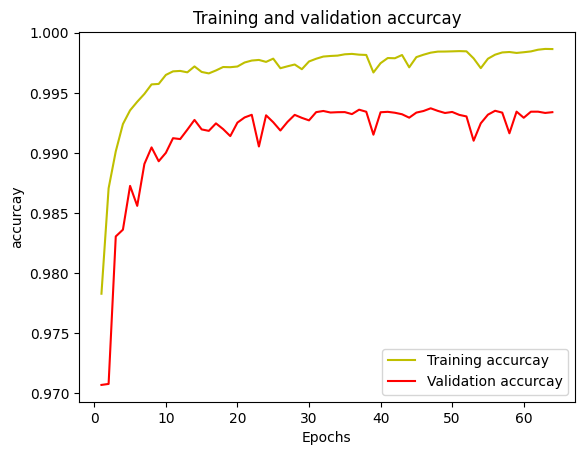

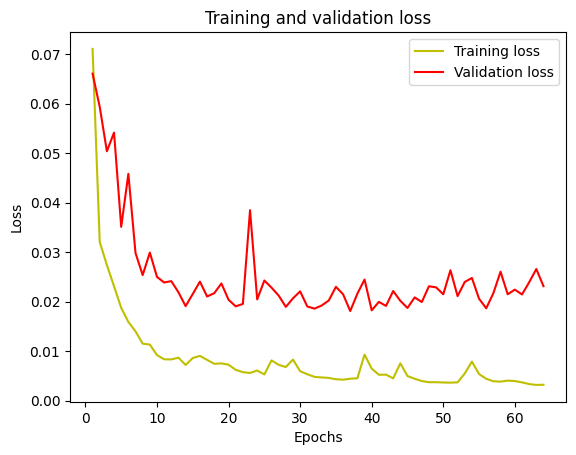

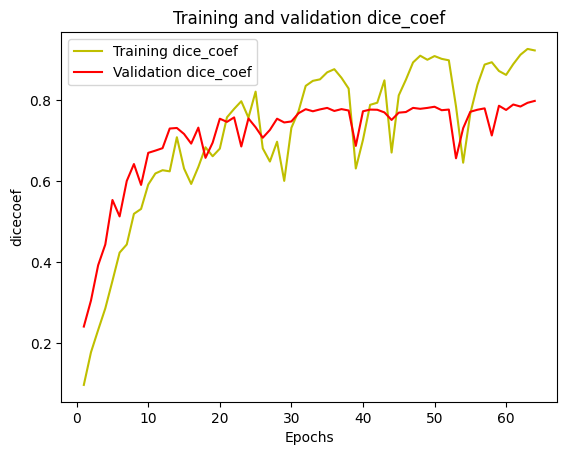

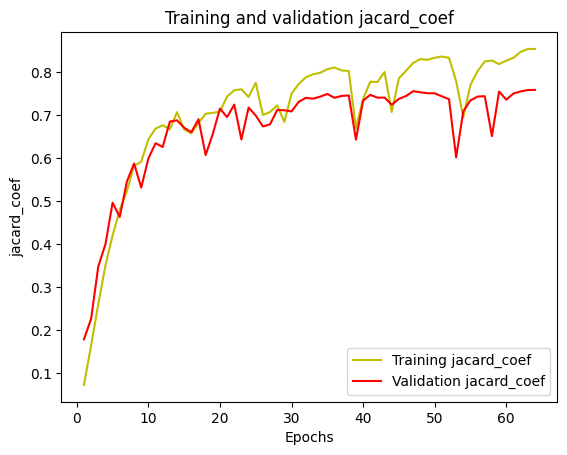

In [ ]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3
inputs=Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=inputs
#Encoding
c1=Conv2D(16,(3,3),input_shape=X_train.shape[1:],activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=MaxPooling2D((2,2))(c1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4= MaxPooling2D(pool_size=(2,2))(c4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
#Decoding
u6= Conv2DTranspose(128,(2,2),strides=(2, 2),padding='same')(c5)
u6= concatenate([u6, c4])
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
u7= Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(c6)
u7= concatenate([u7,c3])
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
u8= Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8= concatenate([u8, c2])
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
u9= Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9= concatenate([u9,c1],axis=3)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)
outputs= Conv2D(1,(1,1),activation='sigmoid')(c9)
model8=Model(inputs=[inputs],outputs=[outputs])

model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,jacard_coef])
results8=model8.fit(X_train,y_train,validation_split=0.1,batch_size=16,epochs=64)

accuracy = results8.history['accuracy']
val_accuracy= results8.history['val_accuracy']
epochs = range(1,len(accuracy) + 1)
plt.plot(epochs,accuracy,'y',label='Training accurcay')
plt.plot(epochs,val_accuracy,'r', label='Validation accurcay')
plt.title('Training and validation accurcay')
plt.xlabel('Epochs')
plt.ylabel('accurcay')
plt.legend()
plt.show()

loss =results8.history['loss']
val_loss=results8.history['val_loss']
epochs =range(1, len(loss) + 1)
plt.plot(epochs,loss, 'y', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dicecoef =results8.history['dice_coef']
val_dice_coef = results8.history['val_dice_coef']
plt.plot(epochs,dicecoef,'y', label='Training dice_coef')
plt.plot(epochs,val_dice_coef, 'r', label='Validation dice_coef')
plt.title('Training and validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('dicecoef')
plt.legend()
plt.show()

jacardcoef =results8.history['jacard_coef']
val_jacard_coef= results8.history['val_jacard_coef']
plt.plot(epochs,jacardcoef, 'y', label='Training jacard_coef')
plt.plot(epochs, val_jacard_coef,'r', label='Validation jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('jacard_coef')
plt.legend()
plt.show()

#Model7:128*128,No drop out ,batch_size=64,epochs=100وoptimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,IoU]


Epoch 1/100
63/63 [==============================] - 35s 236ms/step - loss: 0.0942 - accuracy: 0.9866 - dice_coef: 0.0614 - jacard_coef: 0.0428 - val_loss: 0.0748 - val_accuracy: 0.9707 - val_dice_coef: 0.1776 - val_jacard_coef: 0.1209
Epoch 2/100
63/63 [==============================] - 8s 127ms/step - loss: 0.0329 - accuracy: 0.9888 - dice_coef: 0.1625 - jacard_coef: 0.1770 - val_loss: 0.0862 - val_accuracy: 0.9786 - val_dice_coef: 0.2618 - val_jacard_coef: 0.2446
Epoch 3/100
63/63 [==============================] - 8s 129ms/step - loss: 0.0257 - accuracy: 0.9918 - dice_coef: 0.2414 - jacard_coef: 0.3119 - val_loss: 0.0469 - val_accuracy: 0.9847 - val_dice_coef: 0.4563 - val_jacard_coef: 0.4252
Epoch 4/100
63/63 [==============================] - 8s 127ms/step - loss: 0.0200 - accuracy: 0.9932 - dice_coef: 0.3151 - jacard_coef: 0.4083 - val_loss: 0.0390 - val_accuracy: 0.9867 - val_dice_coef: 0.5082 - val_jacard_coef: 0.4591
Epoch 5/100
63/63 [==============================] - 8s 130

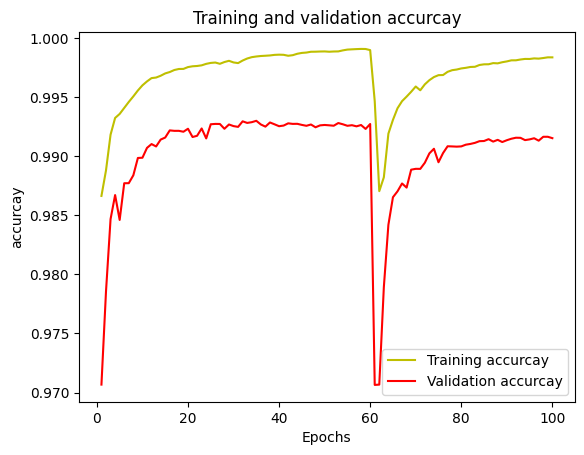

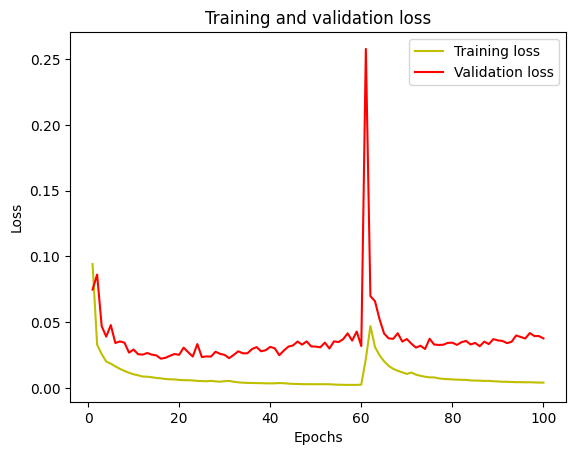

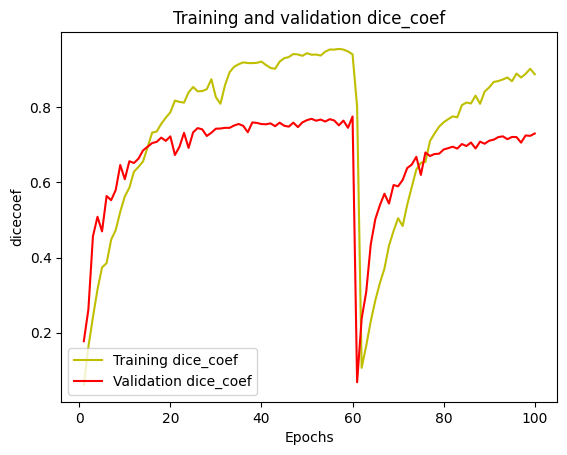

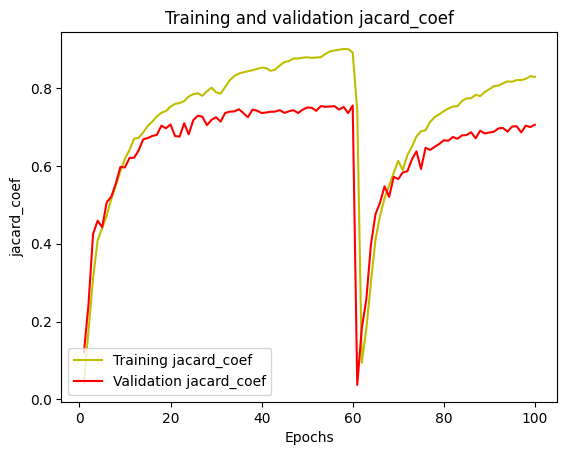

In [ ]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3
inputs=Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=inputs
#Encoding
c1=Conv2D(16,(3,3),input_shape=X_train.shape[1:],activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=MaxPooling2D((2,2))(c1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4= MaxPooling2D(pool_size=(2,2))(c4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
#Decoding
u6= Conv2DTranspose(128,(2,2),strides=(2, 2),padding='same')(c5)
u6= concatenate([u6, c4])
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
u7= Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(c6)
u7= concatenate([u7,c3])
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
u8= Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8= concatenate([u8, c2])
c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
u9= Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9= concatenate([u9,c1],axis=3)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)
outputs= Conv2D(1,(1,1),activation='sigmoid')(c9)
model7=Model(inputs=[inputs],outputs=[outputs])

model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,jacard_coef])
results7=model7.fit(X_train,y_train,validation_split=0.1,batch_size=64,epochs=100)

accuracy = results7.history['accuracy']
val_accuracy= results7.history['val_accuracy']
epochs = range(1,len(accuracy) + 1)
plt.plot(epochs,accuracy,'y',label='Training accurcay')
plt.plot(epochs,val_accuracy,'r', label='Validation accurcay')
plt.title('Training and validation accurcay')
plt.xlabel('Epochs')
plt.ylabel('accurcay')
plt.legend()
plt.show()

loss =results7.history['loss']
val_loss=results7.history['val_loss']
epochs =range(1, len(loss) + 1)
plt.plot(epochs,loss, 'y', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dicecoef =results7.history['dice_coef']
val_dice_coef = results7.history['val_dice_coef']
plt.plot(epochs,dicecoef,'y', label='Training dice_coef')
plt.plot(epochs,val_dice_coef, 'r', label='Validation dice_coef')
plt.title('Training and validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('dicecoef')
plt.legend()
plt.show()

jacardcoef =results7.history['jacard_coef']
val_jacard_coef= results7.history['val_jacard_coef']
plt.plot(epochs,jacardcoef, 'y', label='Training jacard_coef')
plt.plot(epochs, val_jacard_coef,'r', label='Validation jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('jacard_coef')
plt.legend()
plt.show()

#Model6:128*128,No drop out ,batch_size=32,epochs=128 optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,IoU]


Epoch 1/128
125/125 [==============================] - 26s 128ms/step - loss: 0.0763 - accuracy: 0.9781 - dice_coef: 0.0850 - jacard_coef: 0.0707 - val_loss: 0.0692 - val_accuracy: 0.9710 - val_dice_coef: 0.2282 - val_jacard_coef: 0.1705
Epoch 2/128
125/125 [==============================] - 9s 70ms/step - loss: 0.0320 - accuracy: 0.9892 - dice_coef: 0.1782 - jacard_coef: 0.1955 - val_loss: 0.0545 - val_accuracy: 0.9816 - val_dice_coef: 0.3667 - val_jacard_coef: 0.3186
Epoch 3/128
125/125 [==============================] - 9s 70ms/step - loss: 0.0270 - accuracy: 0.9914 - dice_coef: 0.2301 - jacard_coef: 0.2936 - val_loss: 0.0588 - val_accuracy: 0.9806 - val_dice_coef: 0.3430 - val_jacard_coef: 0.3029
Epoch 4/128
125/125 [==============================] - 9s 68ms/step - loss: 0.0234 - accuracy: 0.9924 - dice_coef: 0.2658 - jacard_coef: 0.3507 - val_loss: 0.0428 - val_accuracy: 0.9856 - val_dice_coef: 0.4843 - val_jacard_coef: 0.4469
Epoch 5/128
125/125 [==============================] -

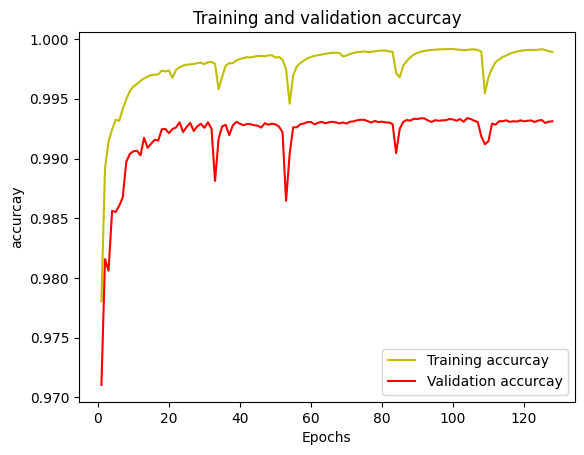

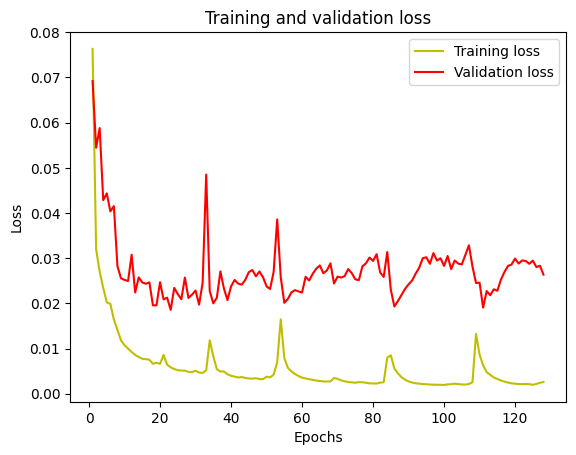

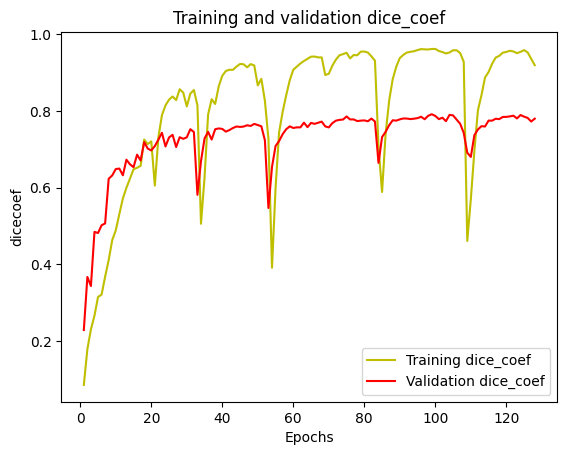

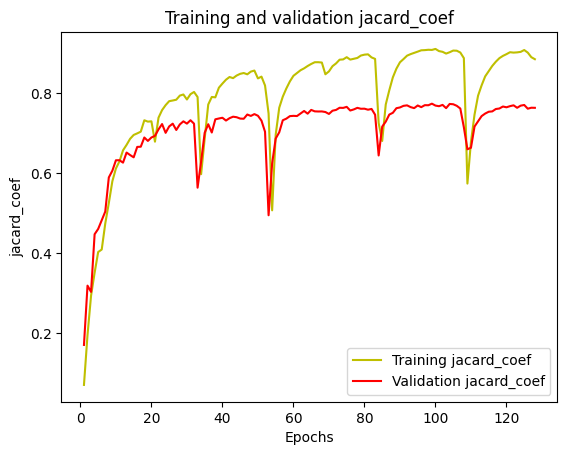

In [ ]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3
inputs=Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=inputs
#Encoding
c1=Conv2D(16,(3,3),input_shape=X_train.shape[1:],activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=MaxPooling2D((2,2))(c1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4= MaxPooling2D(pool_size=(2,2))(c4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
#Decoding
u6= Conv2DTranspose(128,(2,2),strides=(2, 2),padding='same')(c5)
u6= concatenate([u6, c4])
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
u7= Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(c6)
u7= concatenate([u7,c3])
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
u8= Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8= concatenate([u8, c2])
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
u9= Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9= concatenate([u9,c1],axis=3)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)
outputs= Conv2D(1,(1,1),activation='sigmoid')(c9)
model6=Model(inputs=[inputs],outputs=[outputs])

model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,jacard_coef])
results6=model6.fit(X_train,y_train,validation_split=0.1,batch_size=32,epochs=128)

accuracy = results6.history['accuracy']
val_accuracy= results6.history['val_accuracy']
epochs = range(1,len(accuracy) + 1)
plt.plot(epochs,accuracy,'y',label='Training accurcay')
plt.plot(epochs,val_accuracy,'r', label='Validation accurcay')
plt.title('Training and validation accurcay')
plt.xlabel('Epochs')
plt.ylabel('accurcay')
plt.legend()
plt.show()

loss =results6.history['loss']
val_loss=results6.history['val_loss']
epochs =range(1, len(loss) + 1)
plt.plot(epochs,loss, 'y', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dicecoef =results6.history['dice_coef']
val_dice_coef = results6.history['val_dice_coef']
plt.plot(epochs,dicecoef,'y', label='Training dice_coef')
plt.plot(epochs,val_dice_coef, 'r', label='Validation dice_coef')
plt.title('Training and validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('dicecoef')
plt.legend()
plt.show()

jacardcoef =results6.history['jacard_coef']
val_jacard_coef= results6.history['val_jacard_coef']
plt.plot(epochs,jacardcoef, 'y', label='Training jacard_coef')
plt.plot(epochs, val_jacard_coef,'r', label='Validation jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('jacard_coef')
plt.legend()
plt.show()

#Model5:128*128,No drop out ,batch_size=16,epochs=128 optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,IoU]


In [ ]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3
inputs=Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=inputs
#Encoding
c1=Conv2D(16,(3,3),input_shape=X_train.shape[1:],activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=MaxPooling2D((2,2))(c1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4= MaxPooling2D(pool_size=(2,2))(c4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
#Decoding
u6= Conv2DTranspose(128,(2,2),strides=(2, 2),padding='same')(c5)
u6= concatenate([u6, c4])
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
u7= Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(c6)
u7= concatenate([u7,c3])
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
u8= Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8= concatenate([u8, c2])
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
u9= Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9= concatenate([u9,c1],axis=3)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)
outputs= Conv2D(1,(1,1),activation='sigmoid')(c9)
model5=Model(inputs=[inputs],outputs=[outputs])

model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,jacard_coef])
results5=model5.fit(X_train,y_train,validation_split=0.1,batch_size=16,epochs=128)

Epoch 1/128
250/250 [==============================] - 32s 52ms/step - loss: 0.0722 - accuracy: 0.9809 - dice_coef: 0.1156 - jacard_coef: 0.0922 - val_loss: 0.0618 - val_accuracy: 0.9781 - val_dice_coef: 0.2876 - val_jacard_coef: 0.2186
Epoch 2/128
250/250 [==============================] - 11s 42ms/step - loss: 0.0292 - accuracy: 0.9911 - dice_coef: 0.2157 - jacard_coef: 0.2578 - val_loss: 0.0465 - val_accuracy: 0.9853 - val_dice_coef: 0.4224 - val_jacard_coef: 0.3626
Epoch 3/128
250/250 [==============================] - 9s 36ms/step - loss: 0.0247 - accuracy: 0.9924 - dice_coef: 0.2595 - jacard_coef: 0.3405 - val_loss: 0.0517 - val_accuracy: 0.9847 - val_dice_coef: 0.4488 - val_jacard_coef: 0.4199
Epoch 4/128
250/250 [==============================] - 9s 35ms/step - loss: 0.0224 - accuracy: 0.9928 - dice_coef: 0.2819 - jacard_coef: 0.3723 - val_loss: 0.0498 - val_accuracy: 0.9840 - val_dice_coef: 0.4363 - val_jacard_coef: 0.4102
Epoch 5/128
250/250 [==============================] -

KeyError: 'accurcay'

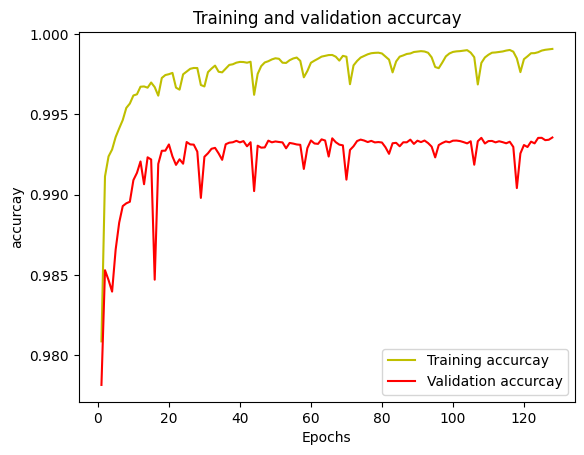

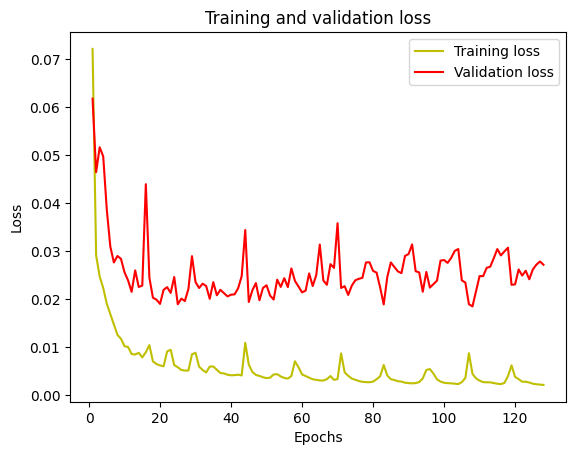

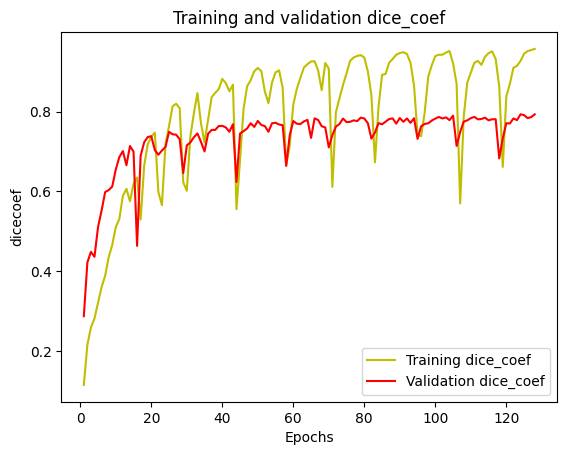

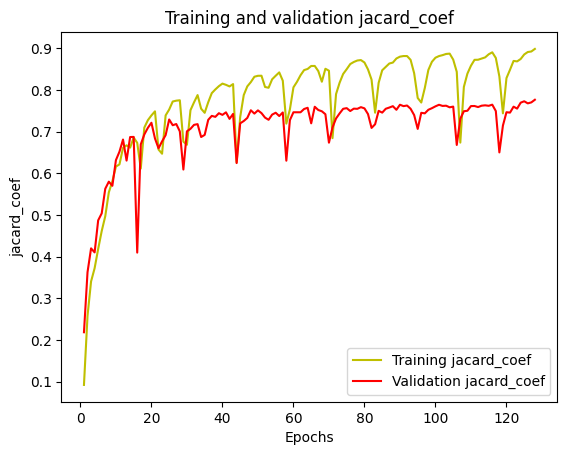

In [ ]:
accuracy = results5.history['accuracy']
val_accuracy= results5.history['val_accuracy']
epochs = range(1,len(accuracy) + 1)
plt.plot(epochs,accuracy,'y',label='Training accurcay')
plt.plot(epochs,val_accuracy,'r', label='Validation accurcay')
plt.title('Training and validation accurcay')
plt.xlabel('Epochs')
plt.ylabel('accurcay')
plt.legend()
plt.show()

loss =results5.history['loss']
val_loss=results5.history['val_loss']
epochs =range(1, len(loss) + 1)
plt.plot(epochs,loss, 'y', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dicecoef =results5.history['dice_coef']
val_dice_coef = results5.history['val_dice_coef']
plt.plot(epochs,dicecoef,'y', label='Training dice_coef')
plt.plot(epochs,val_dice_coef, 'r', label='Validation dice_coef')
plt.title('Training and validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('dicecoef')
plt.legend()
plt.show()

jacardcoef =results5.history['jacard_coef']
val_jacard_coef= results5.history['val_jacard_coef']
plt.plot(epochs,jacardcoef, 'y', label='Training jacard_coef')
plt.plot(epochs, val_jacard_coef,'r', label='Validation jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('jacard_coef')
plt.legend()
plt.show()

#Model3:128*128, ,batch_size=16,epochs=128 optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef]


In [ ]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3

inputs=Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=inputs
#Encoding
c1=Conv2D(16,(3,3),input_shape=X_train.shape[1:],activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=Dropout(0.2)(c1)
c1=Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=MaxPooling2D((2,2))(c1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=Dropout(0.2)(c2)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3= Dropout(0.2)(c3)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4= Dropout(0.2)(c4)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4= MaxPooling2D(pool_size=(2,2))(c4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5= Dropout(0.3)(c5)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
#Decoding
u6= Conv2DTranspose(128,(2,2),strides=(2, 2),padding='same')(c5)
u6= concatenate([u6, c4])
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6= Dropout(0.2)(c6)
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
u7= Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(c6)
u7= concatenate([u7,c3])
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7= Dropout(0.2)(c7)
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
u8= Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8= concatenate([u8, c2])
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8= Dropout(0.2)(c8)
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
u9= Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9= concatenate([u9,c1],axis=3)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9= Dropout(0.2)(c9)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)
outputs= Conv2D(1,(1,1),activation='sigmoid')(c9)
model4=Model(inputs=[inputs],outputs=[outputs])

model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,jacard_coef])
results4=model4.fit(X_train,y_train,validation_split=0.1,batch_size=16,epochs=128)

accurcay =results4.history['accurcay']
val_accurcay= results4.history['val_accurcay']
epochs= range(1, len(loss) + 1)
plt.plot(epochs, accurcay,'y', label='Training accurcay')
plt.plot(epochs, val_accurcay,'r', label='Validation accurcay')
plt.title('Training and validation accurcay')
plt.xlabel('Epochs')
plt.ylabel('accurcay')
plt.legend()
plt.show()

loss =results4.history['loss']
val_loss = results4.history['val_loss']
epochs= range(1, len(loss)+ 1)
plt.plot(epochs, loss,'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dicecoef =results4.history['dice_coef']
val_dice_coef= results4.history['val_dice_coef']
plt.plot(epochs, dicecoef, 'y', label='Training dice_coef')
plt.plot(epochs,val_dice_coef, 'r', label='Validation dice_coef')
plt.title('Training and validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('dicecoef')
plt.legend()
plt.show()

jacardcoef =results4.history['jacard_coef']
val_jacard_coef=results4.history['val_jacard_coef']
plt.plot(epochs,jacardcoef, 'y', label='Training jacard_coef')
plt.plot(epochs,val_jacard_coef, 'r', label='Validation jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('jacard_coef')
plt.legend()
plt.show()

Epoch 1/128
250/250 [==============================] - 20s 52ms/step - loss: 0.0979 - accuracy: 0.9867 - dice_coef: 0.0782 - jacard_coef: 0.0632 - val_loss: 0.0654 - val_accuracy: 0.9713 - val_dice_coef: 0.2570 - val_jacard_coef: 0.1858
Epoch 2/128
250/250 [==============================] - 12s 49ms/step - loss: 0.0334 - accuracy: 0.9890 - dice_coef: 0.1820 - jacard_coef: 0.1812 - val_loss: 0.0574 - val_accuracy: 0.9811 - val_dice_coef: 0.3505 - val_jacard_coef: 0.2891
Epoch 3/128
250/250 [==============================] - 12s 50ms/step - loss: 0.0299 - accuracy: 0.9907 - dice_coef: 0.2087 - jacard_coef: 0.2496 - val_loss: 0.0514 - val_accuracy: 0.9830 - val_dice_coef: 0.4341 - val_jacard_coef: 0.3789
Epoch 4/128
250/250 [==============================] - 13s 50ms/step - loss: 0.0255 - accuracy: 0.9920 - dice_coef: 0.2500 - jacard_coef: 0.3232 - val_loss: 0.0473 - val_accuracy: 0.9829 - val_dice_coef: 0.4679 - val_jacard_coef: 0.4022
Epoch 5/128
250/250 [==============================]

#Model3:128*128, ,batch_size=32,epochs=100 optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef]


Epoch 1/100
250/250 [==============================] - 20s 55ms/step - loss: 0.0577 - accuracy: 0.9833 - dice_coef: 0.1174 - jacard_coef: 0.1182 - val_loss: 0.0573 - val_accuracy: 0.9801 - val_dice_coef: 0.3252 - val_jacard_coef: 0.2695
Epoch 2/100
250/250 [==============================] - 13s 54ms/step - loss: 0.0287 - accuracy: 0.9911 - dice_coef: 0.2037 - jacard_coef: 0.2741 - val_loss: 0.0496 - val_accuracy: 0.9838 - val_dice_coef: 0.4423 - val_jacard_coef: 0.4031
Epoch 3/100
250/250 [==============================] - 13s 53ms/step - loss: 0.0239 - accuracy: 0.9926 - dice_coef: 0.2516 - jacard_coef: 0.3501 - val_loss: 0.0440 - val_accuracy: 0.9853 - val_dice_coef: 0.4523 - val_jacard_coef: 0.3984
Epoch 4/100
250/250 [==============================] - 13s 52ms/step - loss: 0.0229 - accuracy: 0.9929 - dice_coef: 0.2654 - jacard_coef: 0.3707 - val_loss: 0.0435 - val_accuracy: 0.9846 - val_dice_coef: 0.4983 - val_jacard_coef: 0.4408
Epoch 5/100
250/250 [==============================]

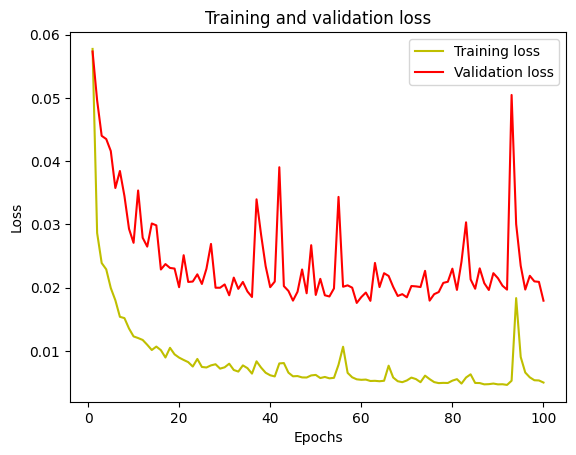

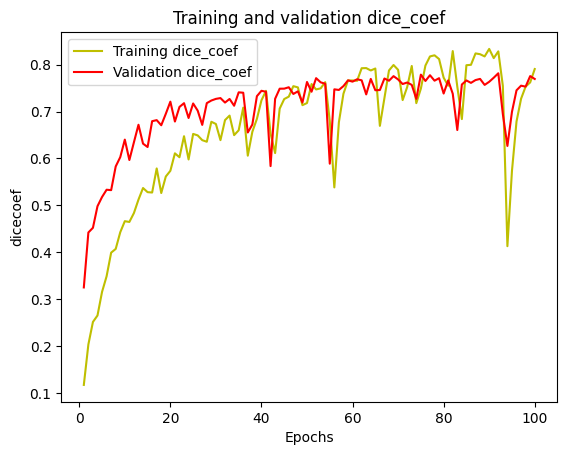

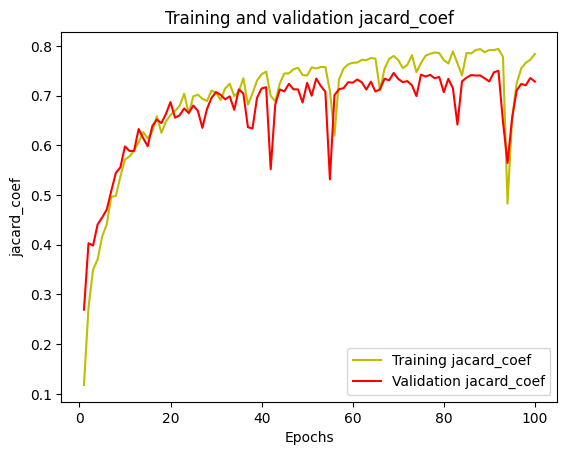

In [ ]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3

inputs=Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=inputs
#Encoding
c1=Conv2D(16,(3,3),input_shape=X_train.shape[1:],activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=Dropout(0.2)(c1)
c1=Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=MaxPooling2D((2,2))(c1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=Dropout(0.2)(c2)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3= Dropout(0.2)(c3)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4= Dropout(0.2)(c4)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4= MaxPooling2D(pool_size=(2,2))(c4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5= Dropout(0.3)(c5)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
#Decoding
u6= Conv2DTranspose(128,(2,2),strides=(2, 2),padding='same')(c5)
u6= concatenate([u6, c4])
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6= Dropout(0.2)(c6)
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
u7= Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(c6)
u7= concatenate([u7,c3])
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7= Dropout(0.2)(c7)
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
u8= Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8= concatenate([u8, c2])
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8= Dropout(0.2)(c8)
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
u9= Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9= concatenate([u9,c1],axis=3)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9= Dropout(0.2)(c9)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)
outputs= Conv2D(1,(1,1),activation='sigmoid')(c9)
model3 = Model(inputs=[inputs], outputs=[outputs])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,jacard_coef])
results3=model3.fit(X_train,y_train,validation_split=0.1,batch_size=16,epochs=100)
loss = results3.history['loss']
val_loss = results3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs,loss, 'y', label='Training loss')
plt.plot(epochs,val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dicecoef = results3.history['dice_coef']
val_dice_coef =results3.history['val_dice_coef']
plt.plot(epochs,dicecoef, 'y', label='Training dice_coef')
plt.plot(epochs,val_dice_coef, 'r', label='Validation dice_coef')
plt.title('Training and validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('dicecoef')
plt.legend()
plt.show()

jacardcoef =results3.history['jacard_coef']
val_jacard_coef = results3.history['val_jacard_coef']
plt.plot(epochs,jacardcoef, 'y', label='Training jacard_coef')
plt.plot(epochs,val_jacard_coef, 'r', label='Validation jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('jacard_coef')
plt.legend()
plt.show()

#Model3:128*128, ,batch_size=16,epochs=100 optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef]


Epoch 1/100
250/250 [==============================] - 29s 67ms/step - loss: 0.0926 - accuracy: 0.9787 - dice_coef: 0.0933 - jacard_coef: 0.0770 - val_loss: 0.0720 - val_accuracy: 0.9713 - val_dice_coef: 0.2432 - val_jacard_coef: 0.1651
Epoch 2/100
250/250 [==============================] - 13s 51ms/step - loss: 0.0328 - accuracy: 0.9885 - dice_coef: 0.1765 - jacard_coef: 0.1702 - val_loss: 0.0587 - val_accuracy: 0.9802 - val_dice_coef: 0.3316 - val_jacard_coef: 0.2573
Epoch 3/100
250/250 [==============================] - 13s 51ms/step - loss: 0.0281 - accuracy: 0.9915 - dice_coef: 0.2200 - jacard_coef: 0.2875 - val_loss: 0.0588 - val_accuracy: 0.9826 - val_dice_coef: 0.3876 - val_jacard_coef: 0.3535
Epoch 4/100
250/250 [==============================] - 15s 58ms/step - loss: 0.0242 - accuracy: 0.9925 - dice_coef: 0.2567 - jacard_coef: 0.3430 - val_loss: 0.0465 - val_accuracy: 0.9848 - val_dice_coef: 0.4387 - val_jacard_coef: 0.3945
Epoch 5/100
250/250 [==============================]

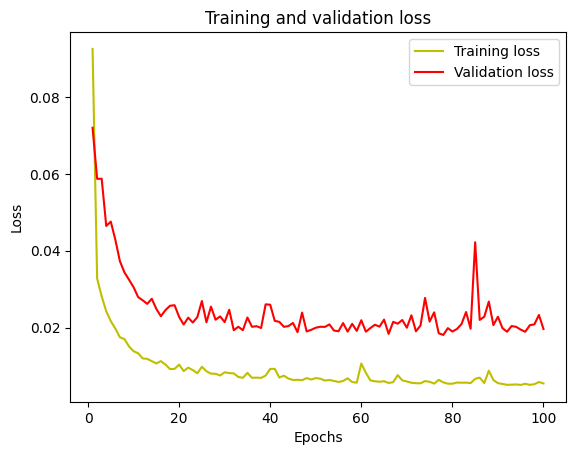

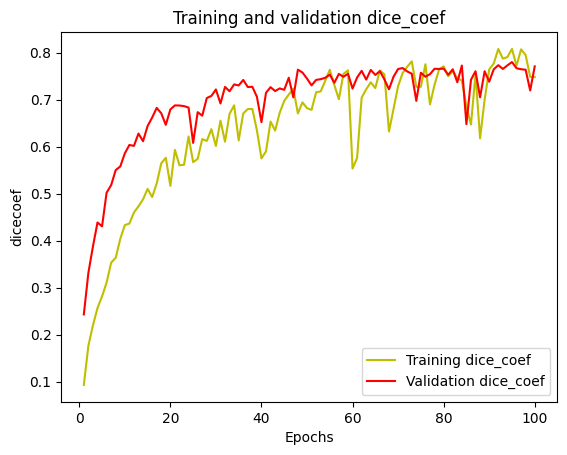

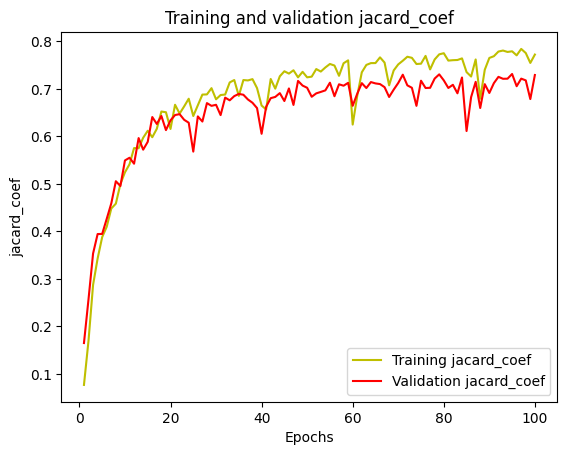

In [ ]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3

inputs=Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=inputs
#Encoding
c1=Conv2D(16,(3,3),input_shape=X_train.shape[1:],activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=Dropout(0.2)(c1)
c1=Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=MaxPooling2D((2,2))(c1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=Dropout(0.2)(c2)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3= Dropout(0.2)(c3)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4= Dropout(0.2)(c4)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4= MaxPooling2D(pool_size=(2,2))(c4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5= Dropout(0.3)(c5)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
#Decoding
u6= Conv2DTranspose(128,(2,2),strides=(2, 2),padding='same')(c5)
u6= concatenate([u6, c4])
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6= Dropout(0.2)(c6)
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
u7= Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(c6)
u7= concatenate([u7,c3])
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7= Dropout(0.2)(c7)
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
u8= Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8= concatenate([u8, c2])
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8= Dropout(0.2)(c8)
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
u9= Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9= concatenate([u9,c1],axis=3)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9= Dropout(0.2)(c9)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)
outputs= Conv2D(1,(1,1),activation='sigmoid')(c9)
model3 = Model(inputs=[inputs], outputs=[outputs])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,jacard_coef])
results3=model3.fit(X_train,y_train,validation_split=0.1,batch_size=16,epochs=100)
loss = results3.history['loss']
val_loss = results3.history['val_loss']
epochs = range(1,len(loss) + 1)
plt.plot(epochs,loss, 'y', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dicecoef =results3.history['dice_coef']
val_dice_coef= results3.history['val_dice_coef']
plt.plot(epochs,dicecoef, 'y', label='Training dice_coef')
plt.plot(epochs,val_dice_coef,'r', label='Validation dice_coef')
plt.title('Training and validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('dicecoef')
plt.legend()
plt.show()

jacardcoef = results3.history['jacard_coef']
val_jacard_coef=results3.history['val_jacard_coef']
plt.plot(epochs,jacardcoef,'y', label='Training jacard_coef')
plt.plot(epochs, val_jacard_coef, 'r', label='Validation jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('jacard_coef')
plt.legend()
plt.show()

#Proposed Model:64*64, batch_size=16,epochs=100,optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,jacard_coef]


Epoch 1/100
250/250 [==============================] - 22s 30ms/step - loss: 0.0612 - accuracy: 0.9795 - dice_coef: 0.1430 - jacard_coef: 0.0890 - val_loss: 0.0677 - val_accuracy: 0.9701 - val_dice_coef: 0.2558 - val_jacard_coef: 0.1947
Epoch 2/100
250/250 [==============================] - 4s 16ms/step - loss: 0.0311 - accuracy: 0.9891 - dice_coef: 0.2384 - jacard_coef: 0.1909 - val_loss: 0.0508 - val_accuracy: 0.9828 - val_dice_coef: 0.4069 - val_jacard_coef: 0.3375
Epoch 3/100
250/250 [==============================] - 4s 16ms/step - loss: 0.0238 - accuracy: 0.9923 - dice_coef: 0.3088 - jacard_coef: 0.3289 - val_loss: 0.0447 - val_accuracy: 0.9836 - val_dice_coef: 0.4831 - val_jacard_coef: 0.4315
Epoch 4/100
250/250 [==============================] - 5s 19ms/step - loss: 0.0208 - accuracy: 0.9931 - dice_coef: 0.3596 - jacard_coef: 0.3888 - val_loss: 0.0481 - val_accuracy: 0.9848 - val_dice_coef: 0.4886 - val_jacard_coef: 0.4574
Epoch 5/100
250/250 [==============================] - 

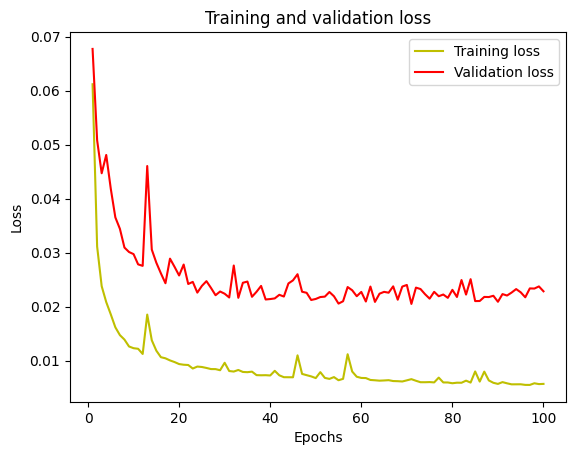

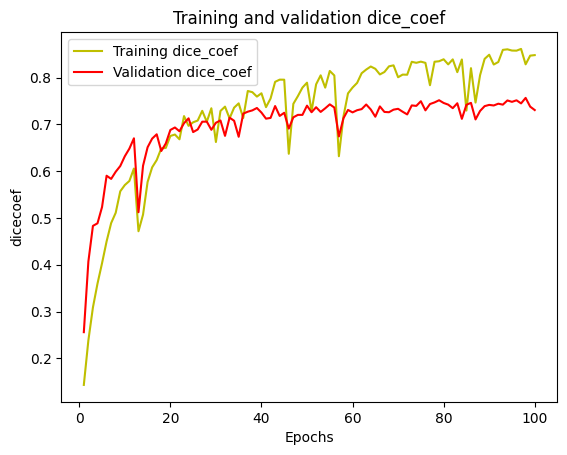

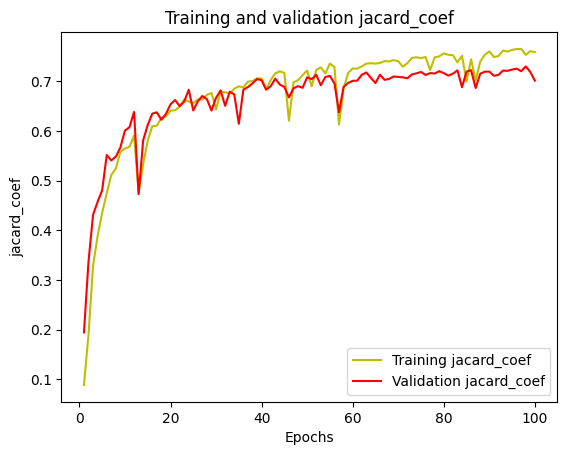

In [ ]:
IMG_HEIGHT=64
IMG_WIDTH=64
IMG_CHANNELS=3

inputs=Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=inputs
#Encoding
c1=Conv2D(16,(3,3),input_shape=X_train.shape[1:],activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=Dropout(0.2)(c1)
c1=Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=MaxPooling2D((2,2))(c1)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=Dropout(0.2)(c2)
c2=Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3= Dropout(0.2)(c3)
c3= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4= Dropout(0.2)(c4)
c4= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4= MaxPooling2D(pool_size=(2,2))(c4)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5= Dropout(0.3)(c5)
c5= Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
#Decoding
u6= Conv2DTranspose(128,(2,2),strides=(2, 2),padding='same')(c5)
u6= concatenate([u6, c4])
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6= Dropout(0.2)(c6)
c6= Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
u7= Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(c6)
u7= concatenate([u7,c3])
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7= Dropout(0.2)(c7)
c7= Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
u8= Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8= concatenate([u8, c2])
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8= Dropout(0.2)(c8)
c8= Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
u9= Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9= concatenate([u9,c1],axis=3)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9= Dropout(0.2)(c9)
c9= Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)
outputs= Conv2D(1,(1,1),activation='sigmoid')(c9)
proposed_model = Model(inputs=[inputs], outputs=[outputs])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,jacard_coef])
results3=model3.fit(X_train,y_train,validation_split=0.1,batch_size=16,epochs=100)
loss = results3.history['loss']
val_loss =results3.history['val_loss']
epochs =range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dicecoef =results3.history['dice_coef']
val_dice_coef =results3.history['val_dice_coef']
plt.plot(epochs,dicecoef,'y', label='Training dice_coef')
plt.plot(epochs,val_dice_coef, 'r', label='Validation dice_coef')
plt.title('Training and validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('dicecoef')
plt.legend()
plt.show()

jacardcoef =results3.history['jacard_coef']
val_jacard_coef= results3.history['val_jacard_coef']
plt.plot(epochs,jacardcoef,'y', label='Training jacard_coef')
plt.plot(epochs, val_jacard_coef, 'r', label='Validation jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('jacard_coef')
plt.legend()
plt.show()

#Model:64*64وbatch_size=32,epochs=128,loss='binary_crossentropy', metrics=['accuracy',dice_coef]

#Evaluation

In [13]:
y_pred=model5.predict(X_test)

16/16 [==============================] - 4s 98ms/step


In [15]:
y_pred_=y_pred>0.5
y_pred_thresholded=y_pred_.astype(int)
min_value = np.min(y_pred_thresholded)
max_value = np.max(y_pred_thresholded)
print("Minimum value in y_pred_thresholded:", min_value)
print("Maximum value in y_pred_thresholded:", max_value)
unique_values = np.unique(y_pred_thresholded)
print("Unique values in y_pred_thresholded:", unique_values)


Minimum value in y_pred_thresholded: 0
Maximum value in y_pred_thresholded: 1
Unique values in y_pred_thresholded: [0 1]


In [16]:
#IOU
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.91803896


In [ ]:
results = model5.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])
print("Test dice coef:", results[2])
print("Test jacard coef:", results[3])

31/31 [==============================] - 1s 17ms/step - loss: 0.0112 - accuracy: 0.9975 - dice_coef: 0.8622 - jacard_coef: 0.7720
Test Loss: 0.011173075996339321
Test Accuracy: 0.9974997639656067
Test dice coef: 0.8621870875358582
Test jacard coef: 0.7719519734382629


1/1 [==============================] - 0s 18ms/step


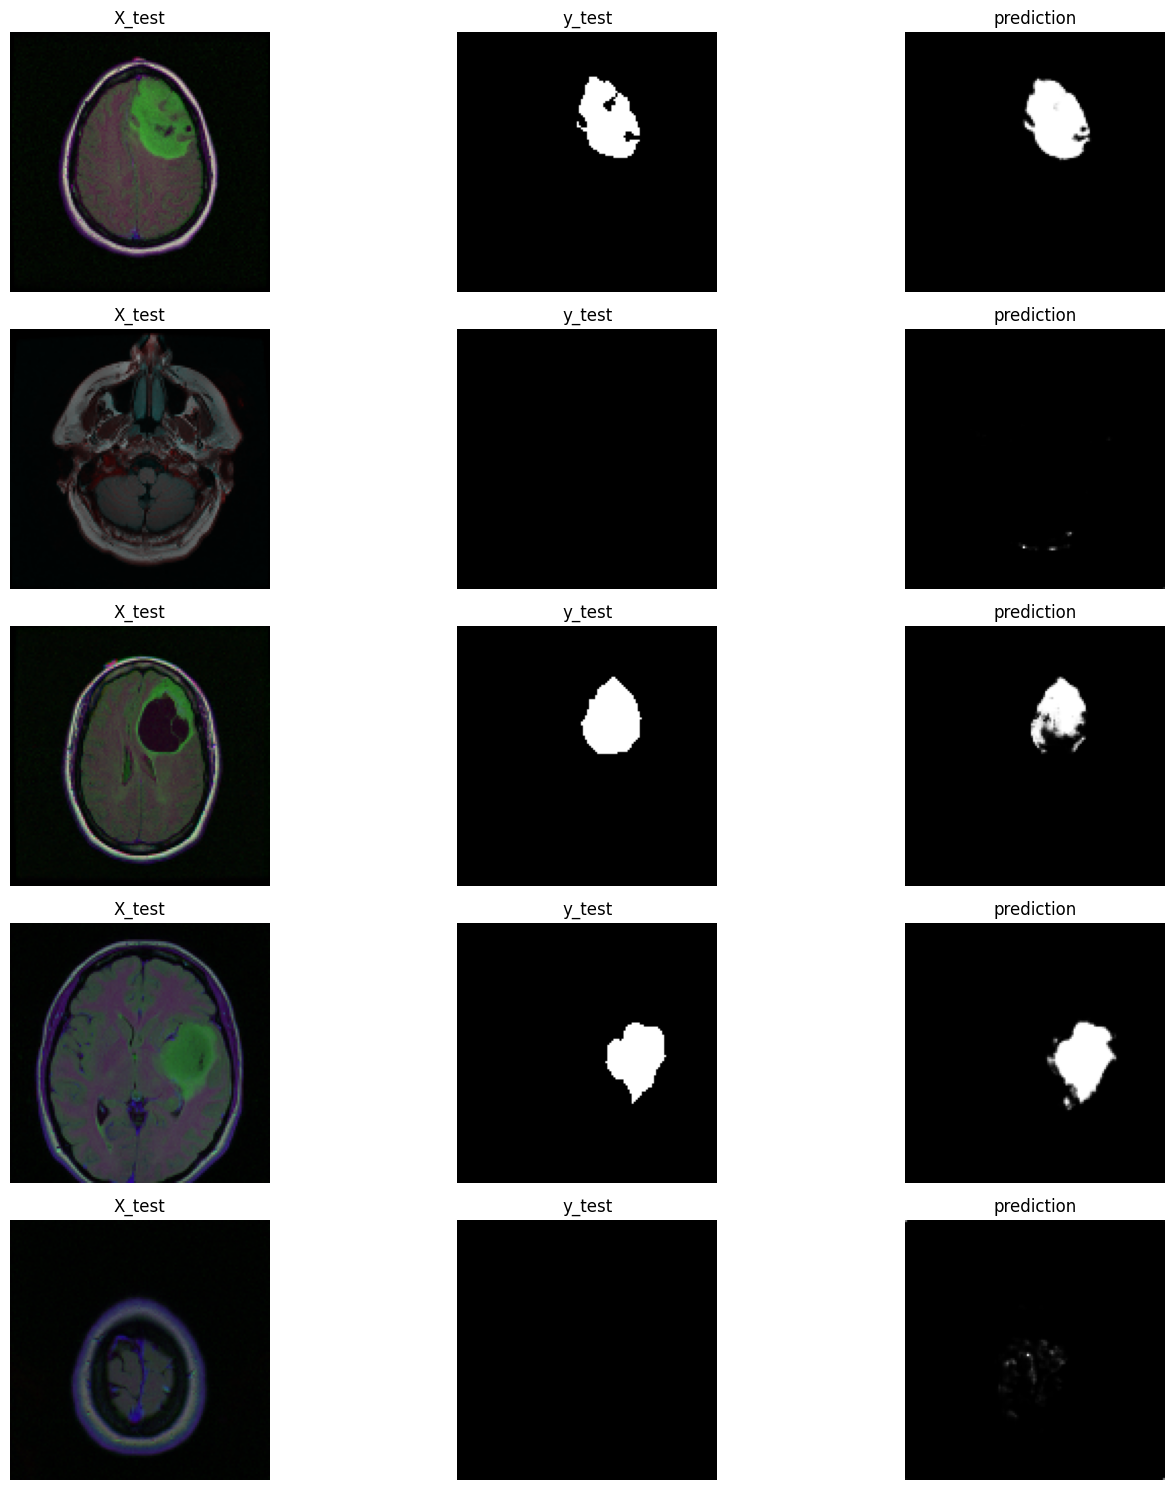

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(15, 15))
iiid=np.random.randint(0,len(X_test),size=5)
for i,ww in zip(range(5),iiid):
    axs[i, 0].imshow(X_test[ww])
    axs[i, 0].set_title('X_test')
    axs[i, 1].imshow(y_test[ww],cmap='gray')
    axs[i, 1].set_title('y_test')
    sample_prediction = model5.predict(np.expand_dims(X_test[ww], axis=0))
    axs[i, 2].imshow(sample_prediction[0],cmap='gray')
    axs[i, 2].set_title('prediction')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')


plt.tight_layout()
plt.show()